# 3. MLSOL

To eliminate imbalance in data, we use the MLSOL oversampling method published in [this paper](https://www.groundai.com/project/synthetic-oversampling-of-multi-label-data-based-on-local-label-distribution/1).

A python implementation of the algorithm is borrowed from [this repo](https://github.com/diliadis/mlsol).

In [1]:
from keras.preprocessing.image import load_img, img_to_array, save_img
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

import pickle
import os
import sys
sys.path.append("../src")

from utils import destination
from mlsol import MLSOL

Using TensorFlow backend.


## Prepare dataset

In [2]:
DATA_LIST = "../HARRISON/data_list.txt"
TAG_LIST = "../HARRISON/1115232904_tag_list.txt"

# Read files
filename = pd.read_csv(DATA_LIST, names=["filename"], header=None)
hashtag = pd.read_csv(TAG_LIST, names=["labels"], header=None)

# Convert filenames from "instagram_dataset/xxx/yyy.jpg" to "xxx_yyy.jpg"
filename["filename"] = filename["filename"].apply(lambda x: "_".join(x.split("/")[1:]))

# Concatenate filname and labels
target = pd.concat([filename, hashtag], axis=1)

# Use vectorizer to generate a one-hot encoding
vectorizer = CountVectorizer(binary=True)
Y = vectorizer.fit_transform(target["labels"])
columns = vectorizer.get_feature_names()
Y_df = pd.DataFrame(Y.toarray(), columns=columns)

# Combine hashtag encodings with file names
target = pd.concat([target, Y_df], axis=1)
target = shuffle(target, random_state=42)

num_images = target.shape[0]
num_hashtags = Y_df.shape[1]

## MLSOL

In [5]:
SRC_DIR = os.path.join("..","HARRISON","images")

# Prepare dataset for MLSOL
images = []
c = 0
for path in os.listdir(SRC_DIR):
    img_path = os.path.join(SRC_DIR, path)
    image = load_img(img_path, target_size=(100, 100))
    img_arr = img_to_array(image).flatten()
    images.append(img_arr)

    b = int(num_images/10)
    if c%b==0 and c!= 0:
        print(f"{c}/{num_images} images loaded")
    c += 1

print(f"{c}/{num_images} images loaded")

5738/57383 images loaded
11476/57383 images loaded
17214/57383 images loaded
22952/57383 images loaded
28690/57383 images loaded
34428/57383 images loaded
40166/57383 images loaded
45904/57383 images loaded
51642/57383 images loaded
57380/57383 images loaded
57383/57383 images loaded


In [ ]:
# Save it for future use
# with open(destination("../model", "img_arr_15.pickle"), "wb") as f:
#     pickle.dump(X, f)

In [6]:
# with open("../model/1115141417_img_arr.pickle", "rb") as f:
#     X = pickle.load(f)
# Y = np.array(Y_df)

In [6]:
# Takes about 6-7 hr
X, Y = np.array(images), np.array(Y_df)

mlsol = MLSOL(perc_gen_instances=0.50, k=5)
X_aug, y_aug = mlsol.fit_resample(X, Y)

Sample 2869/28691 created
Sample 5738/28691 created
Sample 8607/28691 created
Sample 11476/28691 created
Sample 14345/28691 created
Sample 17214/28691 created
Sample 20083/28691 created
Sample 22952/28691 created
Sample 25821/28691 created
Sample 28690/28691 created


In [7]:
with open(destination("../model", "X_aug.pickle"), "wb") as f:
    pickle.dump(X_aug, f, protocol=4)

with open(destination("../model", "y_aug.pickle"), "wb") as f:
    pickle.dump(y_aug, f)

## Check the Blance
Note: This does not capture the result of MLSOL well because MLSOL adds new data points based on local distribution of images.

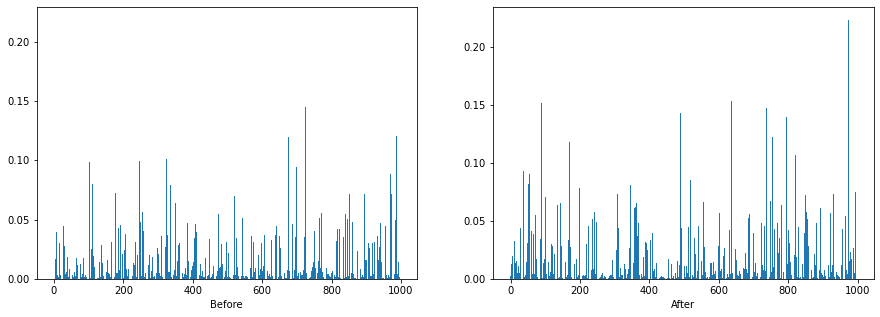

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
x = range(num_hashtags)

ax1.bar(x, Y_df.sum(axis=0)/Y_df.shape[0])
ax1.set(xlabel="Before")
ax2.bar(x, y_aug.sum(axis=0)/y_aug.shape[0])
ax2.set(xlabel="After")

plt.show()

## Examples of Created Samples

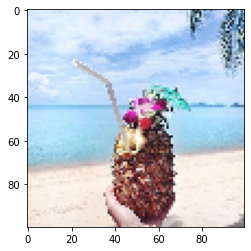

Hashtags: ['adventure', 'artistic', 'bestoftheday', 'blog', 'blue', 'brown', 'classic', 'color', 'creative', 'design', 'epic', 'green', 'instagood', 'orange', 'pink', 'purple', 'rainbow', 'red', 'repost', 'stunning', 'tumblr', 'white', 'yellow', 'youtube']


In [62]:
idx = num_images+24417
plt.imshow(X_aug[idx].reshape(100, 100, 3)/255)
plt.show()
print(f"Hashtags: {list(vectorizer.inverse_transform(y_aug[idx])[0])}")

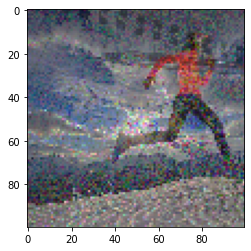

Hashtags: ['amazing', 'awesome', 'beach', 'chill', 'city', 'cool', 'great', 'holiday', 'hot', 'lake', 'nature', 'naturelover', 'naturelovers', 'naturephotography', 'nice', 'park', 'summertime', 'travel', 'trip', 'vacation', 'vsco', 'warm', 'wonderful', 'wow']


In [66]:
idx = num_images+24720
plt.imshow(X_aug[idx].reshape(100, 100, 3)/255)
plt.show()
print(f"Hashtags: {list(vectorizer.inverse_transform(y_aug[idx])[0])}")

## Save Images

In [8]:
num_added = X_aug.shape[0] - num_images

# Save new images
i = 0
for img in X_aug[-num_added:]:
    prefix = os.path.join("..", "HARRISON", "images", "aug_")
    save_img(f"{prefix}{i}.jpg", img.reshape(100, 100, 3))
    i += 1

In [9]:
# Save new tag_list
tag_list = list(target["labels"]) \
    + [' '.join(list(vectorizer.inverse_transform(y_aug[num_images + i])[0]))
        for i in range(num_added)]
with open(destination(os.path.join("..", "HARRISON"), "tag_list_aug.txt"), "w") as f:
    f.writelines("%s\n" % tags for tags in tag_list)

# Save new data_list
data_list = list(target["filename"]) + [f"aug_{i}.jpg" for i in range(num_added)]
with open(destination(os.path.join("..", "HARRISON"), "data_list_aug.txt"), "w") as f:
    f.writelines("%s\n" % line for line in data_list)